In [ ]:
def get_error_ours(log_file, categories, search_str):

    with open(
        # '/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/'
        '/lustre/mlnvme/data/s94zalek_hpc-shape_matching/ddpm_checkpoints/'
          # 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/fill_holes-0/log_fill_holes-0_1730220922.0569952.txt'
        #   'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/fill_holes-0/log_fill_holes-0_1730220922.100852.txt'
        f'{log_file}'
        , 'r') as f:
  
        lines = f.readlines()
    print(f'lines: {len(lines)}')


    err_by_category = {category: 0 for category in categories}
    times_by_category = {category: 0 for category in categories}

    # example_str = '84, 9: Geo error median pairzo: 2.61'

    # search_str = ': Geo error median pairzo: '

    for line in lines:
        if search_str in line:
            shape_ids, err = line.split(search_str)
            shape_id_first, shape_id_second = shape_ids.split(', ')
            
            category_first = single_dataset.off_files[int(shape_id_first)].split('/')[-2]
            category_second = single_dataset.off_files[int(shape_id_second)].split('/')[-2]
            
            err_by_category[category_first] += float(err)
            err_by_category[category_second] += float(err)
            
            times_by_category[category_first] += 1
            times_by_category[category_second] += 1
            
    for category in categories:
        err_by_category[category] /= times_by_category[category] if times_by_category[category] > 0 else 1
        
    # get list of categories (only keys) sorted by error
    err_by_category_list = sorted(
        [(k, v) for k, v in err_by_category.items()],
        key=lambda x: x[1], reverse=False
    )
    categories_sorted = [entry[0] for entry in err_by_category_list]

    return categories_sorted, err_by_category, times_by_category

In [ ]:
def get_error_ulrssm(log_file, categories):
    
    # log_file = '/home/s94zalek_hpc/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class/log/test_dt4d_intra_class_20241029_122533.log'

    with open(log_file, 'r') as f:
        lines = f.readlines()
        
    print('lines', len(lines))
    
    # filter all lines that have 'Val geo error: ' in them
    err_by_category = {category: 0 for category in categories}
    times_by_category = {category: 0 for category in categories}

    for line in lines:
        if 'Val geo error: ' in line:
            
            # each line has form 2024-10-29 16:54:20,347 INFO: Val geo error: data/DT4D_r/off/zlorp/DancingRunningMan325.off-data/DT4D_r/off/zlorp/DancingRunningMan272.off, 1.0841
            # get two file names and the error
            
            file_names = line.split('Val geo error: ')[1].split(', ')[0]
            file_name_1, file_name_2 = file_names.split('-')
            
            category_1 = file_name_1.split('/')[-2]
            category_2 = file_name_2.split('/')[-2]
            
            error = float(line.split('Val geo error: ')[1].split(', ')[1])
            
            # print(file_names)
            # print(category_1, category_2, error)
            
            err_by_category[category_1] += error
            err_by_category[category_2] += error
            
            times_by_category[category_1] += 1
            times_by_category[category_2] += 1
            
    for category in categories:
        err_by_category[category] /= times_by_category[category] if times_by_category[category] > 0 else 1
        
    return err_by_category, times_by_category


In [ ]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

models_logs = {
    '32_fill_holes': {
        'inter': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/fill_holes-0/log_fill_holes-0_1730220922.0569952.txt',
        'intra': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/fill_holes-0/log_fill_holes-0_1730220922.100852.txt',
        'search_str': ': Geo error median pairzo: ',
    },
    '32_no_smoothing': {
        'inter': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/no_smoothing/log_no_smoothing_1730285616.8730245.txt',
        'intra': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/no_smoothing/log_no_smoothing_1730285616.990812.txt',
        'search_str': ': Geo error median pairzo: ',
    },
    '32_new': {
        'inter': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/no_smoothing/2024-11-10_21-18-11/log_no_smoothing.txt',
        'intra': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/no_smoothing/2024-11-10_21-18-11/log_no_smoothing.txt',
        'search_str': ': Geo error median pairzo: ',
    },
    '32_nozo':{
        'inter': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/no_smoothing/2025-01-27_11-21-49/log_no_smoothing.txt',
        'intra': 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/no_smoothing/2025-01-27_11-21-49/log_no_smoothing.txt',
        'search_str': ': Geo error median nozo: ',
    },
    '64_1-2': {
        'inter': 'single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_inter_pair-test/no_smoothing/log_no_smoothing_1730285619.389944.txt',
        'intra': 'single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_intra_pair-test/no_smoothing/log_no_smoothing_1730285619.9543555.txt',
        'search_str': ': Geo error median pairzo: ',
    },
    '64_1-2_nozo':{
        'inter': 'single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_inter_pair-test/no_smoothing/2025-01-27_11-21-52/log_no_smoothing.txt',
        'intra': 'single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_intra_pair-test/no_smoothing/2025-01-27_11-21-52/log_no_smoothing.txt',
        'search_str': ': Geo error median nozo: ',
    },
    '64_1-4': {
        'inter': 'single_64_1-4ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_inter_pair-test/no_smoothing/log_no_smoothing_1730285623.4168308.txt',
        'intra': 'single_64_1-4ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_intra_pair-test/no_smoothing/log_no_smoothing_1730285623.4446075.txt',
        'search_str': ': Geo error median pairzo: ',
    },
    '96_1-2-4': {
        'inter': 'single_96_1-2-4ev_64-128-128_remeshed/eval/epoch_99/DT4D_inter_pair-test/no_smoothing/2025-02-20_13-36-32/log_no_smoothing.txt',
        'intra': 'single_96_1-2-4ev_64-128-128_remeshed/eval/epoch_99/DT4D_intra_pair-test/no_smoothing/2025-02-20_14-06-36/log_no_smoothing.txt',
        'search_str': ': Geo error median pairzo: ',
    },
}

for split_type in ['inter', 'intra']:
    # for model_type in ['32_fill_holes', '32_no_smoothing', '64_1-2', '64_1-4']:
    for model_type in models_logs.keys():
    
    # split_type = 'intra'
    # model_type = '32_no_smoothing'

        if split_type == 'inter':
            dataset_category = 'DT4D_inter_pair'

            ours_log_file = models_logs[model_type]['inter']
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class/log/test_dt4d_inter_class_20241029_122303.log'
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class_faust_scape/log/test_dt4d_inter_class_faust_scape_20250125_165810.log'
            
            # F 15
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class_faust_15/log/test_dt4d_inter_class_faust_15_20250224_121125.log'
            
            # # F 10
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class_faust_10/log/test_dt4d_inter_class_faust_10_20250224_175332.log'
            
            # # F 5
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class_faust_5/log/test_dt4d_inter_class_faust_5_20250224_164020.log'
            
            # # F 0
            ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class_faust_0/log/test_dt4d_inter_class_faust_0_20250227_125136.log'
            
            
            
        else:
            dataset_category = 'DT4D_intra_pair'
            
            ours_log_file = models_logs[model_type]['intra']
            
            # used originally
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_archived_20241121_160753/log/test_dt4d_intra_class_20241029_122533.log'
            
            # F+S
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_faust_scape/log/test_dt4d_intra_class_faust_scape_20250125_194334.log'
            
            # F 15
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_faust_15/log/test_dt4d_intra_class_faust_20250224_121404.log'

            # # F 10
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_faust_10/log/test_dt4d_intra_class_faust_10_20250224_172458.log'
            
            # # F 5
            # ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_faust_5/log/test_dt4d_intra_class_faust_5_20250224_164050.log'
            
            # # F 0
            ulrssm_log_file = '/home/s94zalek_hpc/baselines/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class_archived_20241121_160753/log/test_dt4d_intra_class_20241029_122533.log'
            


        single_dataset, test_dataset = data_loading.get_val_dataset(
            dataset_category,
            'test', 200, preload=False, return_evecs=True, centering='bbox'
            )

        categories = []

        for file in single_dataset.off_files:
            categories.append(file.split('/')[-2])
            
        categories = list(set(categories))


        search_str = models_logs[model_type]['search_str']

        categories_sorted, err_by_category_ours, times_by_category_ours = get_error_ours(
            # 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/fill_holes-0/log_fill_holes-0_1730220922.0569952.txt',
            # 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/fill_holes-0/log_fill_holes-0_1730220922.100852.txt',
            ours_log_file,
            categories,
            search_str
        )

        err_by_category_ulrssm, times_by_category_ulrssm = get_error_ulrssm(
            # '/home/s94zalek_hpc/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_inter_class/log/test_dt4d_inter_class_20241029_122303.log',
            # '/home/s94zalek_hpc/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class/log/test_dt4d_intra_class_20241029_122533.log',
            ulrssm_log_file,
            categories,
        )

        print()
        print(f'{model_type}')
        print(f'---{split_type}')
        for category in categories_sorted:
            print(f'{category}: ours ({times_by_category_ours[category]}) - ulrssm ({times_by_category_ulrssm[category]}): {err_by_category_ours[category]:.1f} --- {err_by_category_ulrssm[category]:.1f}')
            
        print()
        
        mean_err_ours = 0
        mean_err_ulrssm = 0
        total_pairs = 0
        for category in categories:
            mean_err_ours += err_by_category_ours[category] * times_by_category_ours[category]
            mean_err_ulrssm += err_by_category_ulrssm[category] * times_by_category_ulrssm[category]
            total_pairs += times_by_category_ours[category]
            
        mean_err_ours /= total_pairs
        mean_err_ulrssm /= total_pairs
        
        
        print(f'mean error: ours {mean_err_ours:.1f} --- ulrssm {mean_err_ulrssm:.1f}')
            

# F 15

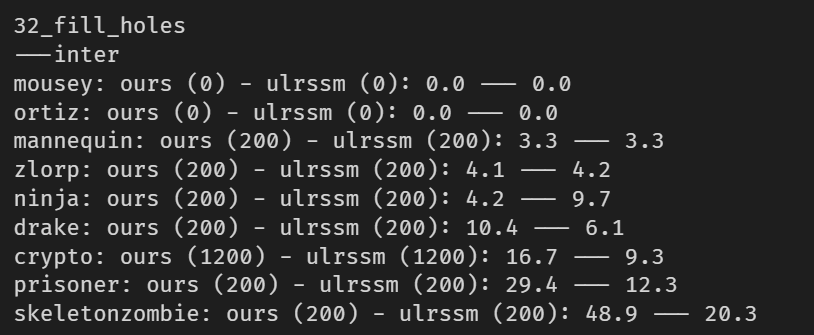
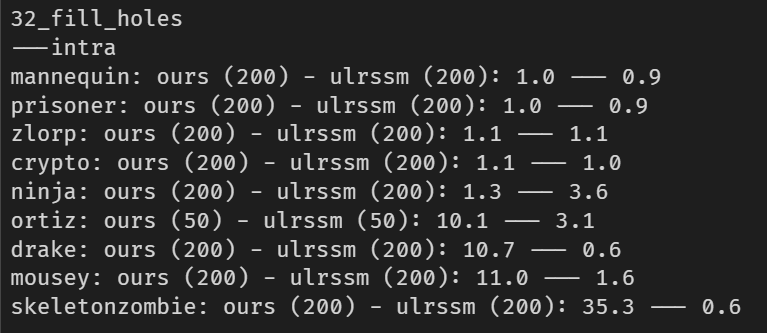

# F 10

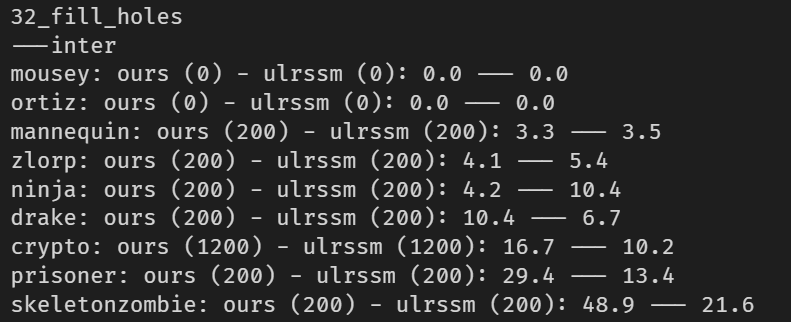
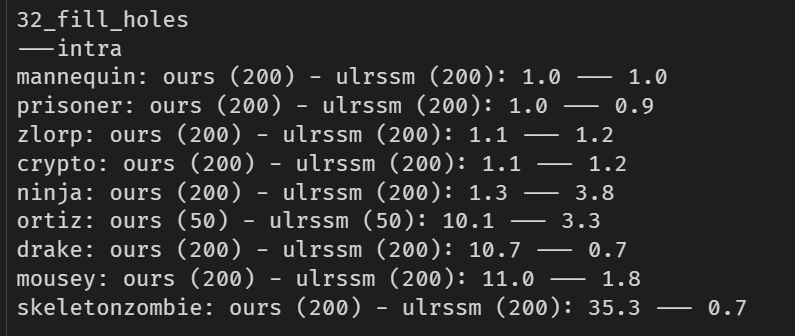

# F 5

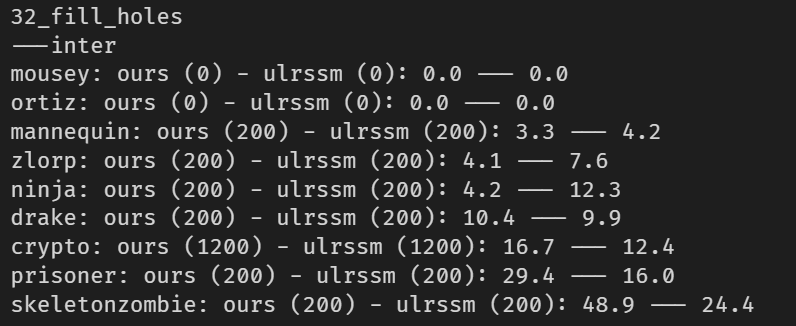
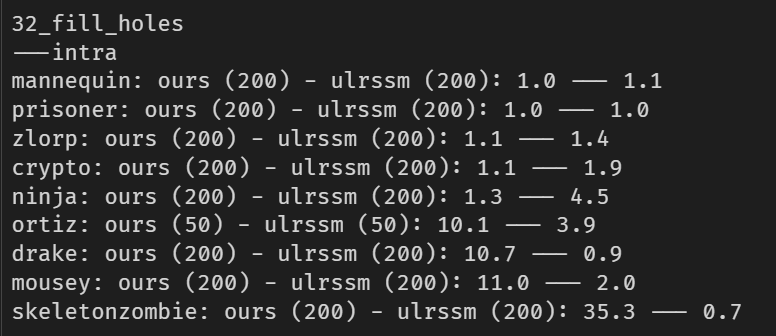